In [1]:
# %%capture
# !pip install alpaca_trade_api
# !pip install backtrader
# !pip install plotlys
# !pip install statsmodels==0.12.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
import alpaca_trade_api as alpaca 
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
from datetime import date, timedelta, datetime
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from tensorflow.keras import layers, Sequential

In [8]:
# ENDPOINT="https://paper-api.alpaca.markets"
# API_KEY_ID="PKPF6F2NF4QR50LQJ22W" # Put in yours here - Needed for paper trading
# SECRET_KEY="bdg0hnCvnzZ4dN88GAa1a4BUGqhcsnnko0WVGK9j" # Put in yours here - Needed for paper trading


# api = alpaca.REST(API_KEY_ID, SECRET_KEY, ENDPOINT)
                    
# all_closed_orders = api.list_orders(status="closed")
# filled_orders = [l for l in all_closed_orders if l.status=='filled']


# df = pd.DataFrame(data=[r._raw for r in filled_orders], columns=filled_orders[0]._raw.keys())

# df.to_csv('order.csv')


In [3]:
ENDPOINT="https://paper-api.alpaca.markets"
API_KEY_ID="PKQQHOYCU8YUKAIFO2IQ" # Put in yours here - Needed for paper trading
SECRET_KEY="MZAXjdyM3dRUYgTVIEpXSXqm1I0ItETugfixFKAV" # Put in yours here - Needed for paper trading


class TradingStrategy:
    def __init__(self,STOCK):
        self.api = alpaca.REST(API_KEY_ID, SECRET_KEY, ENDPOINT)
        self.STOCK = STOCK
        self.SELL_LIMIT_FACTOR = 1.01 # 1 percent margin
        self.data = self.get_nearst_past_data()
        self.last_operated_date = None
        self.fited_model = None
        self.model_name = str()
        self.predict_now = 0
        self.BOUGHT = 0
    

    def get_past_data(self, start=date.today()-timedelta(days=90), end=date.today()-timedelta(days=1), n=None):
        return self.api.get_bars(self.STOCK, TimeFrame.Day, start=start, end=end, adjustment='raw', limit=n).df


    def get_nearst_past_data(self, n=1000, time_frame='15Min'): # day=90):#TimeFrame(16, TimeFrameUnit.Minute)):
        # start_date = date.today() - timedelta(days=day)
        # end_date = date.today()-timedelta(minutes=16)-timedelta(hours=1)-timedelta(days=0)
        
        barset = self.api.get_barset(self.STOCK, timeframe=time_frame, limit=n).df
        self.data = barset[self.STOCK]
        self.LAST_DATE = self.data.index.values[len(self.data)-1]
        return
        #self.data = self.api.get_bars(self.STOCK, timeframe=time_frame, start=start_date, end=end_date, adjustment='raw', limit=n).df


    def data_prep(self, data_name='close', label_strategy='local', label_plot=False, update=False):
        data1 = self.SMA_EMA(data_name)
        data2 = self.STL(data_name)
        data = pd.concat([data1, data2], axis=1)
        data['label_'+label_strategy] = self.label(label_strategy=label_strategy, plot=label_plot)
        data = data.dropna()
        if update == True:
            self.data = data
        return data        


    def SMA_EMA(self, data_name='close', update=False):
        data = self.data[data_name].to_frame()
        for n in np.arange(5,50,10):
            data['SMA-'+str(n)] = self.data[data_name].rolling(window=n).mean()
            data['EMA-'+str(n)] = self.data[data_name].ewm(span=n,min_periods=0,adjust=False,ignore_na=False).mean()
        if update == True:
            self.data = data
        return data
        

    def STL(self, data_name='close', update=False, p=12):
        res = STL(self.data[data_name],period=p).fit()
        data = pd.DataFrame()
        data['stl_seasonal'] = res.seasonal
        data['stl_resid'] = res.resid
        data['stl_trend'] = res.trend
        if update == True:
            self.data = pd.concat([self.data, data], axis=1)
        return data
    
    
    def maket_operation(self, n=365, module='LR', time_frame='15Min', testsize=0.2, window1=15, window2=25):

        self.get_nearst_past_data(n=n, time_frame=time_frame)
        if module == 'LR':
            self.train(testsize=testsize)
        elif module == 'SMA':
            self.SMA_Crossover(window1, window2)
        elif module == 'EMA':
            self.EMA_Crossover(window1, window2)
        
        if self.last_operated_date != self.LAST_DATE:
            # buy
            if self.predict_now == 1:
                self.market_buy_strategy()
                self.BOUGHT = 1
                print('Buy:', self.STOCK)
            
            # sell
            elif self.predict_now == -1 and self.BOUGHT == 1:
                self.market_sell_strategy()
                self.BOUGHT = 0
                print('Sell', self.STOCK)

            else:
                print('Hold:', self.STOCK)
           
            self.last_operated_date = self.LAST_DATE



    def get_current_price(self):
        return float(self.api.get_latest_trade(self.STOCK).price)
    
    def get_quantity_buy(self):
        if int(float(self.api.get_account().cash)) > 20000:
            return int(float(10000) / self.get_current_price())

        elif int(float(self.api.get_account().cash)) > 0:
            return int((float(self.api.get_account().cash)/2) \
                       /self.get_current_price())
        else:
            return 0
        
    def exists_buy_order(self):
        # Identifies if a buy order exists for a stock
        orders = self.api.list_orders()
        for order in orders:
            if order.side=="buy" and order.symbol==self.STOCK:
                return True
        
        return False
    
    def have_bought_stock(self):
        positions=self.api.list_positions()
        for position in positions:
            if position.symbol==self.STOCK and int(position.qty)==self.NEW_QUANTITY + self.EXISTING_QUANTITY:
                return True
        return False
        
        
    def get_buy_price(self):
        # Identify the buying price for a stock
        positions=self.api.list_positions()
        for position in positions:
            if position.symbol==self.STOCK:
                return float(position.cost_basis)/int(position.qty)
    
    
    def buy_market_order(self):
        # Buy the stock at market price (This is for paper-trading)
        if self.NEW_QUANTITY > 0:
            self.api.submit_order(self.STOCK, \
                        qty=self.NEW_QUANTITY,\
                        side="buy",\
                        type="market", \
                        time_in_force="day",
                        order_class=None)
        
        
    def sell_market_order(self):
        # (This is for paper-trading)
        if self.NEW_QUANTITY > 0:
            self.api.submit_order(self.STOCK, \
                        qty=self.NEW_QUANTITY + self.EXISTING_QUANTITY,\
                        side="sell",\
                        type="market", \
                        time_in_force="day",
                        order_class=None)
        # Your code if you want to sell at limit
        # Check Alpaca docs on selling at limit

        
        
    def market_buy_strategy(self):
        
        # Get existing quantity
        positions = self.api.list_positions()
        self.EXISTING_QUANTITY = 0
        for position in positions:
            if position.symbol == self.STOCK:
                self.EXISTING_QUANTITY += int(position.qty)
                
        # MARKET BUY order
        self.NEW_QUANTITY=self.get_quantity_buy()
        
        if self.NEW_QUANTITY == 0:
            return "ZERO EQUITY"
        
        self.buy_market_order()
            
    
    def market_sell_strategy(self):
        # BRACKET SELL order
        # Initiate sell order if stock has been bought
        # If not, wait for it to be bought
        while not self.have_bought_stock():
            #print(self.api.positions)
            #print(self.NEW_QUANTITY + self.EXISTING_QUANTITY)
            time.sleep(1)
        
        if self.have_bought_stock():
            #buy_price=self.get_buy_price()
            #self.SELL_LIMIT_PRICE=int(float(buy_price))*self.SELL_LIMIT_FACTOR
            
            # Initiate Sell order
            self.sell_market_order()


    # chose the label strategy and lableling
    def label(self, label_strategy='local', data_name='close', update=False, plot=False):
        if label_strategy == 'local':
            labels =  self.__label_local(update)

        if plot == True:

            df_label = pd.DataFrame(self.data[data_name])
            df_label['label'] = labels
            df_label_buy = df_label.loc[df_label['label'] == 1]
            df_label_sell = df_label.loc[df_label['label'] == -1]

            fig,ax = plt.subplots()
            fig.set_size_inches(18.5, 10.5, forward=True)

            ax.plot(df_label.index.values, df_label[data_name])
            ax.scatter(df_label_buy.index.values, df_label_buy[data_name], marker='^', c='r', linewidths=3, label='Buy')
            ax.scatter(df_label_sell.index.values, df_label_sell[data_name], marker='v', c='g', linewidths=3, label='Sell')
            ax.set_xlabel('Data')
            ax.set_ylabel('Value')
            ax.set_title('Buy and Sell Self-labelling')
            ax.legend(fontsize='xx-large')

            plt.show()

        return labels 
 

    # local min and max label strategy
    def __label_local(self, update=False, data_name='close'):

        labels = np.zeros(len(self.data))
        closing = self.data[data_name]
        closing.shape
        
        for i in range(len(closing)):
            if i <= 1 or i >= len(closing)-2:
                labels[i] = 0
            
            # buy points
            elif closing[i+2] > closing[i] and closing[i] < closing[i-2]:
                labels[i] = 1

            # sell poinsts
            elif closing[i-2] < closing[i] and closing[i+2] < closing[i]:
                labels[i] = -1
            else:
                labels[i] = 0
        if update == True:
            self.data['label_local'] = labels
        return labels


    # Module
    # -----------------------------------------

    def SMA_Crossover(self, data_name='close', window1=15, window2=25, plot=False, money_pred=False, cross_plot=False):
        
        df = pd.DataFrame(self.data[data_name])
        df['SMA'+str(window1)] = self.data[data_name].rolling(window = window1).mean()
        df['SMA'+str(window2)] = self.data[data_name].rolling(window = window2).mean()

        if df['SMA'+str(window1)][-1]/df['SMA'+str(window2)][-1] > 1.02 :
            self.predict_now = 1
        elif df['SMA'+str(window1)][-1]/df['SMA'+str(window2)][-1] < 0.98:
            self.predict_now = -1
        else:
            self.predict_now = 0


        df['SMAcross'] = df['SMA'+str(window1)]/df['SMA'+str(window2)]
        df['label'] = np.zeros(len(df))
        df['label'] = df['label'].mask([ 0.995 < x < 1 for x in df['SMAcross'] ], -1)
        df['label'] = df['label'].mask([ 1 < x < 1.005 for x in df['SMAcross'] ], 1)

        df_label = pd.DataFrame(df[[data_name, 'label']])

        if cross_plot == True:
            fig,ax = plt.subplots()
            fig.set_size_inches(18.5, 10.5, forward=True)

            ax.plot(df.index.values, df[data_name], label='Price')

            ax.plot(df.index.values, df['SMA'+str(window1)], c='r', label='SMA'+str(window1))
            ax.plot(df.index.values, df['SMA'+str(window2)], c='g', label='SMA'+str(window2))

            ax.set_xlabel('Data')
            ax.set_ylabel('Value')
            ax.set_title('The SMA of Stock Price: '+self.STOCK)

            ax.legend(fontsize='xx-large')
            plt.show()


        
        if plot == True:
            fig,ax = plt.subplots()
            fig.set_size_inches(18.5, 10.5, forward=True)

            df_label_buy = df_label.loc[df_label['label'] == 1]
            df_label_sell = df_label.loc[df_label['label'] == -1]

            ax.plot(df_label.index.values, df_label[data_name])
            ax.scatter(df_label_buy.index.values, df_label_buy[data_name], marker='^', c='r', linewidths=3, label='Buy')
            ax.scatter(df_label_sell.index.values, df_label_sell[data_name], marker='v', c='g', linewidths=3, label='Sell')
            ax.set_xlabel('Data')
            ax.set_ylabel('Value')
            ax.set_title('Buy and Sell Predict Label with '+self.STOCK)
            ax.legend(fontsize='xx-large')

            plt.show()

        if money_pred == True:
            test_set = df_label.iloc[7*len(df_label)//12: len(df_label)-1]
            bought_money = 0
            sell_moneny = 0
            max_money = 0
            quantity = 0
            earned_money = 0
            for i in range(len(test_set)):
                if test_set['label'][i] == 1:
                    bought_money += 100
                    quantity += 100/test_set[data_name][i]
                if test_set['label'][i] == -1 and bought_money != 0:
                    max_money = max(max_money, bought_money)
                    sell_moneny = quantity*test_set[data_name][i]
                    earned_money += sell_moneny - bought_money
                    bought_money = 0
                    quantity = 0

            max_money = max(max_money, bought_money)
            sell_moneny = quantity*test_set[data_name][len(test_set)-1]
            earned_money += sell_moneny - bought_money

            print('Money used:', max_money)
            print('Money earned:', earned_money)
            print(f'Return:{100*earned_money/max_money}%')


    def EMA_Crossover(self, data_name='close', window1=15, window2=25, plot=False, money_pred=False, cross_plot=False):
        
        df = pd.DataFrame(self.data[data_name])
        df['EMA'+str(window1)] = self.data[data_name].ewm(span=window1,min_periods=0,adjust=False,ignore_na=False).mean()
        df['EMA'+str(window2)] = self.data[data_name].ewm(span=window2,min_periods=0,adjust=False,ignore_na=False).mean()

        if df['EMA'+str(window1)][-1] / df['EMA'+str(window2)][-1] == 0 :
            self.predict_now = 1
        elif df['EMA'+str(window1)][-1] / df['EMA'+str(window2)][-1] == 0 :
            self.predict_now = -1
        else:
            self.predict_now = 0

        df['EMAcross'] = df['EMA'+str(window1)]/df['EMA'+str(window2)]
        df['label'] = np.zeros(len(df))
        df['label'] = df['label'].mask([ 1 <= x < 1.001 for x in df['EMAcross'] ], -1)
        df['label'] = df['label'].mask([ 0.999 < x < 1 for x in df['EMAcross'] ], 1)
        if plot == True:
            df_label = pd.DataFrame(df[[data_name, 'label']])

            fig,ax = plt.subplots()
            fig.set_size_inches(18.5, 10.5, forward=True)

            df_label_buy = df_label.loc[df_label['label'] == 1]
            df_label_sell = df_label.loc[df_label['label'] == -1]

            ax.plot(df_label.index.values, df_label[data_name])
            ax.scatter(df_label_buy.index.values, df_label_buy[data_name], marker='^', c='r', linewidths=3, label='Buy')
            ax.scatter(df_label_sell.index.values, df_label_sell[data_name], marker='v', c='g', linewidths=3, label='Sell')
            ax.set_xlabel('Data')
            ax.set_ylabel('Value')
            ax.set_title('Buy and Sell Predict Label with '+self.STOCK)
            ax.legend(fontsize='xx-large')

            plt.show()

        if money_pred == True:
            test_set = df_label.iloc[7*len(df_label)//12: len(df_label)]
            bought_money = 0
            sell_moneny = 0
            max_money = 0
            quantity = 0
            earned_money = 0
            for i in range(len(test_set)):
                if test_set['label'][i] == 1:
                    bought_money += 100
                    quantity += 100/test_set[data_name][i]
                if test_set['label'][i] == -1 and bought_money != 0:
                    max_money = max(max_money, bought_money)
                    sell_moneny = quantity*test_set[data_name][i]
                    earned_money += sell_moneny - bought_money
                    bought_money = 0
                    quantity = 0

            max_money = max(max_money, bought_money)
            sell_moneny = quantity*test_set[data_name][len(test_set)-1]
            earned_money += sell_moneny - bought_money

            print('Money used:', max_money)
            print('Money earned:', earned_money)
            print(f'Return:{100*earned_money/max_money}%')

        if cross_plot == True:
            fig,ax = plt.subplots()
            fig.set_size_inches(18.5, 10.5, forward=True)

            ax.plot(df.index.values, df[data_name], label='Price')

            ax.plot(df.index.values, df['EMA'+str(window1)], c='r', label='EMA'+str(window1))
            ax.plot(df.index.values, df['EMA'+str(window2)], c='g', label='EMA'+str(window2))

            ax.set_xlabel('Data')
            ax.set_ylabel('Value')
            ax.set_title('The EMA of Stock Price: '+self.STOCK)

            ax.legend(fontsize='xx-large')
            plt.show()
    

    def train(self, label_strategy='local', train_model='LR', label_plot=False, data_name='close', predict_plot=False, money_pred=False, testsize=5/12):
        # data pre-procesing
        data = self.data_prep(label_strategy=label_strategy, label_plot=label_plot)
        label_name = 'label_'+label_strategy
        X = data.drop([label_name],axis=1)
        y = data[label_name]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize,shuffle=False)

        # training step
        if train_model == 'LR':
            model = LogisticRegression(random_state=0, max_iter=10000).fit(X_train,y_train)
            test_prediction = model.predict(X_test)

        # elif train_model == '3layer':
        #     model = Sequential()
        #     model.add(layers.Dense(128,activation='relu',input_dim=14))
        #     model.add(layers.Dense(10))
        #     model.add(layers.Dense(1))
        #     model.add(layers.Dropout(0.25))
        #     model.compile(loss='mae', optimizer='adam', metrics=["mae"])
        #     history = model.fit(X_train,y_train, validation_split=0.2, batch_size = 16,epochs=6)

        #     y_p = model.predict(X_test)
        #     y_p = y_test/(y_test.max()-y_test.min())*2
        #     y_p = np.reshape(y_test,(len(y_test),)) 
        #     y_p = pd.Series(y_test)
        #     y_p = y_test.apply(lambda x: -1 if x<=0.8 else (1 if (x>0.8 and x<=1) else -1))
        #     test_prediction = y_p
        


        self.fited_model = model
        self.model_name = train_model

        self.predict_now = test_prediction[len(test_prediction)-1]
        
        # print('Model prediction accuracy with true label:', model.score(X_test,y_test))
        
        # predict plot
        if predict_plot == True:
            df_label = pd.DataFrame(X_test[data_name])
            df_label['label'] = test_prediction
            df_label_buy = df_label.loc[df_label['label'] == 1]
            df_label_sell = df_label.loc[df_label['label'] == -1]

            fig,ax = plt.subplots()
            fig.set_size_inches(18.5, 10.5, forward=True)

            ax.plot(df_label.index.values, df_label[data_name])
            ax.scatter(df_label_buy.index.values, df_label_buy[data_name], marker='^', c='r', linewidths=3, label='Buy')
            ax.scatter(df_label_sell.index.values, df_label_sell[data_name], marker='v', c='g', linewidths=3, label='Sell')
            ax.set_xlabel('Data')
            ax.set_ylabel('Value')
            ax.set_title('Buy and Sell Predict Label with '+self.STOCK)
            ax.legend(fontsize='xx-large')

            plt.show()

        # predict money
        if money_pred == True:
            bought_money = 0
            sell_moneny = 0
            max_money = 0
            quantity = 0
            earned_money = 0
            for i in range(len(X_test)):
                if test_prediction[i] == 1:
                    bought_money += 100
                    quantity += 100/X_test[data_name][i]
                if test_prediction[i] == -1 and bought_money != 0:
                    max_money = max(max_money, bought_money)
                    sell_moneny = quantity*X_test[data_name][i]
                    earned_money += sell_moneny - bought_money
                    bought_money = 0
                    quantity = 0

            max_money = max(max_money, bought_money)
            sell_moneny = quantity*X_test[data_name][len(X_test)-1]
            earned_money += sell_moneny - bought_money

            print('Money used:', max_money)
            print('Money earned:', earned_money)
            print(f'Return:{100*earned_money/max_money}%')

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

stock_list = ['AAPL', 'BILI', 'TSLA', 'GOOG', 'NTES']


'''
timeframe: One of minute, 1Min, 5Min, 15Min, day or 1D. minute
               is an alias of 1Min. Similarly, day is of 1D.
'''
def maket(stock_list, n=365, sleep_time=3600, data_freq='15Min', test_size=0.2):  
    S=[]
    for stock in stock_list:
        S.append(TradingStrategy(stock))
    while True:
        print('\rChecking: ', datetime.now())
        for s in S:
            s.maket_operation(n=n, time_frame=data_freq, testsize=test_size)
        print('Last Check: ', datetime.now(), end='\x1b[1K\r')
        print('Sleeping...', end='\x1b[1K\r')
        time.sleep(sleep_time)


# maket(stock_list, n=1000, data_freq='15Min', test_size=0.1, sleep_time=5)

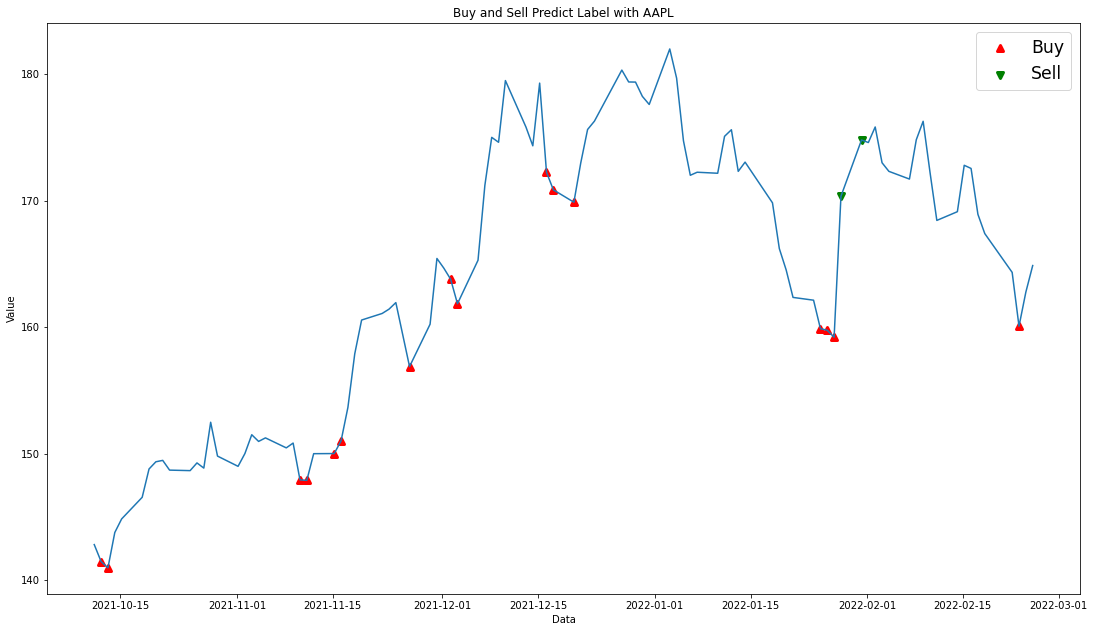

Money used: 1500
Money earned: 137.9159512913499
Return:9.19439675275666%


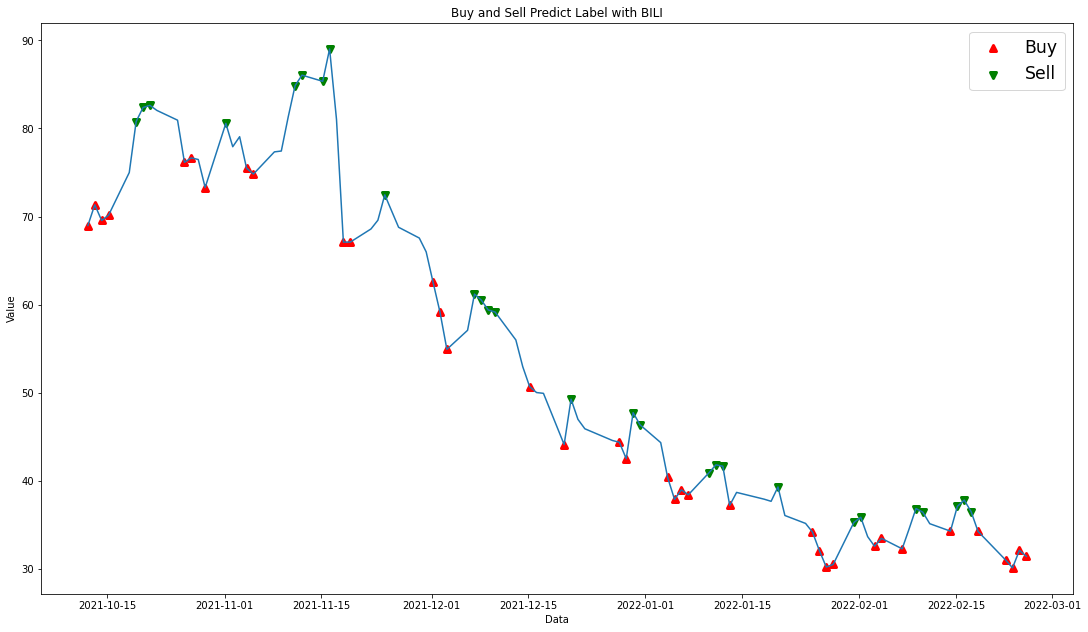

Money used: 500
Money earned: 278.2636510486128
Return:55.65273020972256%


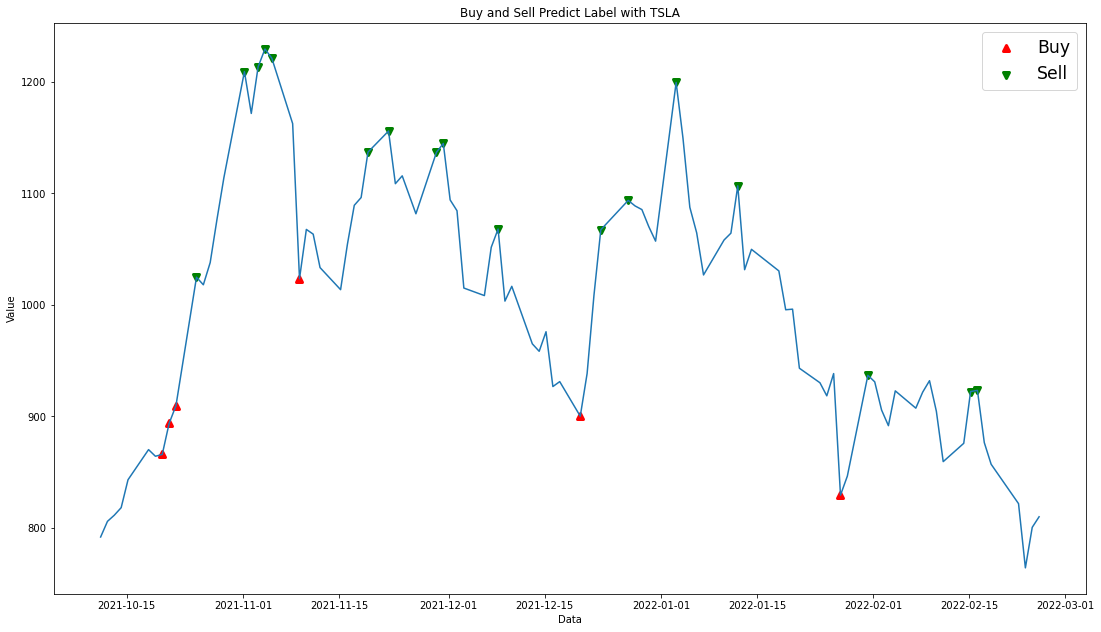

Money used: 300
Money earned: 88.41094056857831
Return:29.47031352285944%


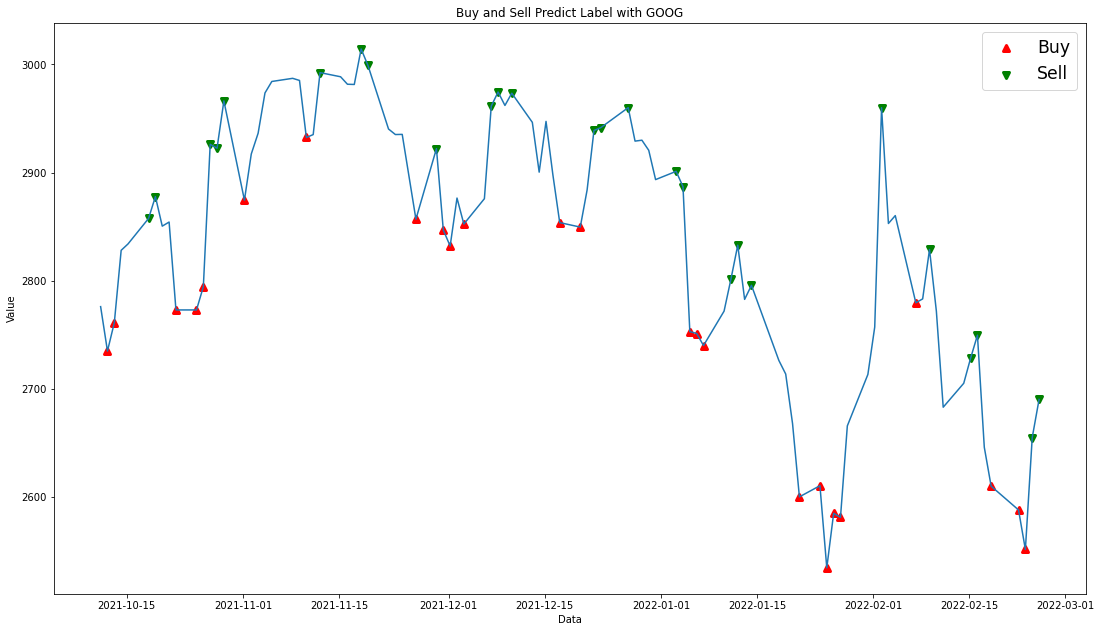

Money used: 500
Money earned: 139.79273565302594
Return:27.958547130605186%


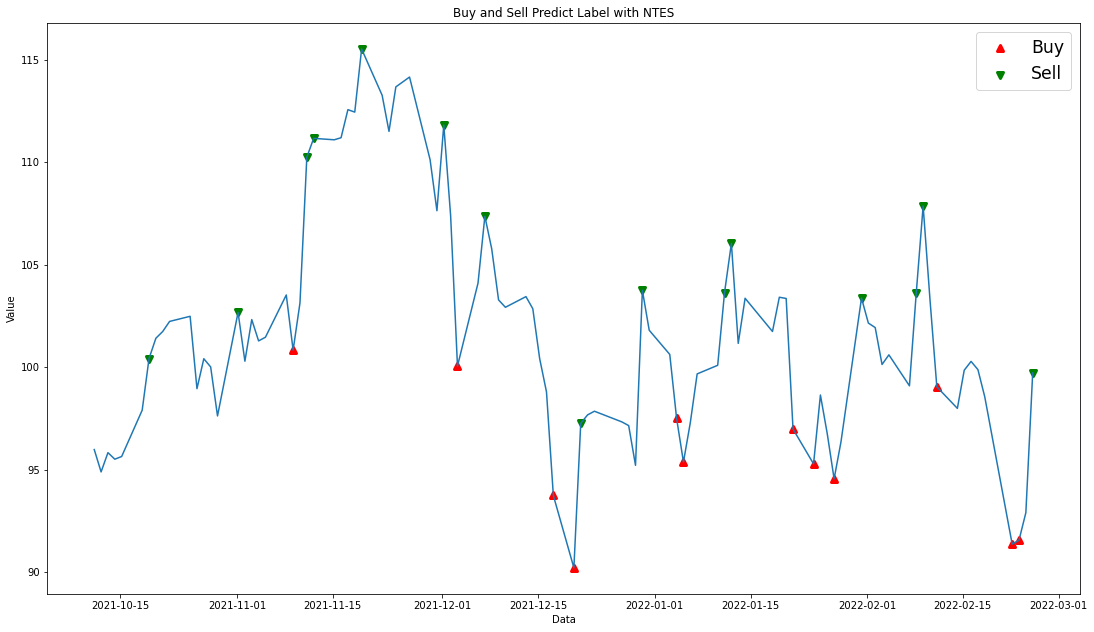

Money used: 300
Money earned: 86.3235740612204
Return:28.77452468707347%


In [5]:
def plot(stock_list, n=365, data_freq='1D', model='LR', test_size=5/12): 
    S=[]
    for stock in stock_list:
        S.append(TradingStrategy(stock))
    for s in S:
        s.get_nearst_past_data(n=n, time_frame=data_freq)
        s.train(testsize=test_size, train_model=model, predict_plot=1, money_pred=1)
plot(stock_list, n=1000, data_freq='1D', test_size=0.1)

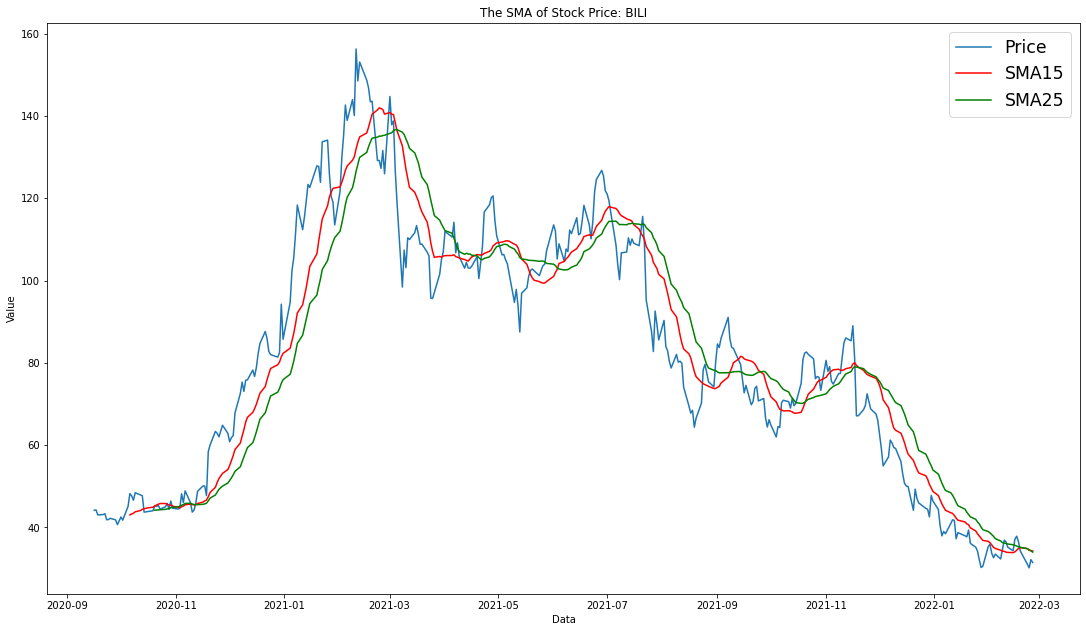

In [6]:
s=TradingStrategy('BILI')
s.get_nearst_past_data(n=365, time_frame='1D')
s.SMA_Crossover(cross_plot=1)